### Inits

In [1]:
# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import *
from scipy.signal import savgol_filter


import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

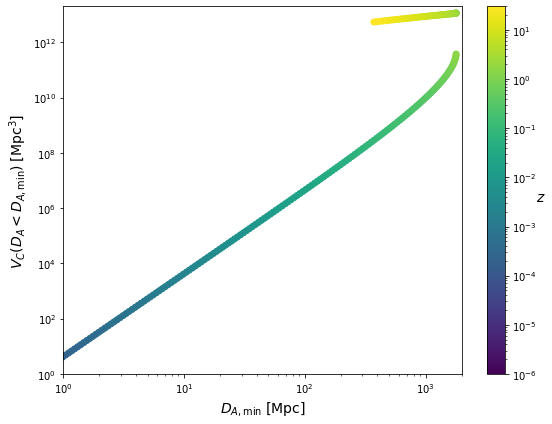

In [5]:
z_lis=np.logspace(-6,np.log10(30),300)

DA_lis=cosmo.angular_diameter_distance(z_lis)
DA_max=np.max(DA_lis)

VC_lis=cosmo.comoving_volume(z_lis)
VC_t=VC_lis[DA_lis==DA_max]
VC_eff=np.append(VC_lis[VC_lis<VC_t],cosmo.comoving_volume(10**7)-VC_lis[VC_lis>=VC_t])


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

sct=ax.scatter(DA_lis,VC_eff,c=z_lis,norm=matplotlib.colors.LogNorm())
# ax.loglog(DA_lis[VC_lis<VC_t],VC_lis[VC_lis<VC_t])
# ax.loglog(DA_lis[VC_lis>=VC_t],VC_lis[-1]-VC_lis[VC_lis>=VC_t])

ax.set_yscale('log')
ax.set_xscale('log')

cbr=plt.colorbar(sct)
cbr.set_label(r'$z$', fontsize=14, rotation=0)

plt.xlim(1,2*10**3)
plt.ylim(1,2*10**13)

plt.ylabel(r'$V_C\left(D_A<D_{A,{\rm min}}\right)\;\left[{\rm Mpc^3}\right]$', fontsize=14)
plt.xlabel(r'$D_{A,{\rm min}}\;\left[{\rm Mpc}\right]$', fontsize=14)

plt.show()

### Data Read

In [6]:
hdul = fits.open('DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=8
m_max=13.5
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=10
dec_max=50

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (dec > dec_min) & (dec < dec_max) & (ra > ra_min) & (ra < ra_max) & (z > z_min) 

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
dist_new=cosmo.comoving_distance(z_new)
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = dist_new)



# Duty-cycle digitized
lam06=np.loadtxt(open('../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

### Functions and constants

In [54]:
#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)


#convertion constatn from M⊙/Mpc to angular size of BH shaddow in μarcsec: 5GM⊙/c^2*Mpc
msun_over_Mpc_to_muas=(5*(const.G*u.M_sun/(const.c**2*u.Mpc))*u.rad).to(u.uas).value

#convertion constatn from M⊙/Mpc*(200 km/sec)^2 to angular size (arcsec) 
# of the gravitational influance size of BH: GM⊙/(200 km/sec)^2*Mpc
msun_over_Mpc_as=((const.G*u.M_sun/((200*u.km/u.s)**2*u.Mpc))*u.rad).to(u.arcsec).value


def Vol(zmin,zmax):
    #Volume of a spherical co-moving shell
    Vsh=(cosmo.comoving_volume(zmax)-cosmo.comoving_volume(zmin))
    #Volume of a 1 steradians section of the shell
    Vstr=Vsh/(4*np.pi)
    #The relevant solid angle
    sa=radians((ra_max-ra_min))*(np.cos(radians(dec_min))-np.cos(radians(dec_max)))
    
    #The Volume
    return Vstr*sa

# Random Arrays

### Restricted region as a function of max distance

In [7]:
def dist_from_RA(RA,ra,dec):
    theta_p=0.0174533*dec
    phi_p=0.0174533*ra
    phi=0.0174533*RA
    return np.sin(theta_p)*np.abs(np.sin(phi-phi_p))

def dist_from_DEC(DEC,dec):
    theta_p=0.0174533*dec
    theta=0.0174533*DEC
    return np.abs(np.sin(theta-theta_p))

def Is_In_rage(ra,dec,rp,rmax):
    x=rmax/rp.value
    return (dist_from_DEC(dec_min,dec)>x) & (dist_from_DEC(dec_max,dec)>x) & (dist_from_RA(ra_max,ra,dec)>x)& (dist_from_RA(ra_min,ra,dec)>x)

In [8]:
def z_ran_max(rmax):
    return z_at_value(cosmo.comoving_distance,cosmo.comoving_distance(z_max)-rmax*u.Mpc)
def z_ran_min(rmax):
    return z_at_value(cosmo.comoving_distance,cosmo.comoving_distance(z_min)+rmax*u.Mpc)

### Generating Arrays

In [9]:
npoints=30
r_max=700 #Mpc


rand_ra=ra_min+(ra_max-ra_min)*(np.random.random_sample((npoints)))
rand_dec=dec_min+(dec_max-dec_min)*(np.random.random_sample((npoints)))
rand_z=z_ran_min(r_max)+(z_ran_max(r_max)-z_ran_min(r_max))*(np.random.random_sample((npoints)))
rand_dis=cosmo.comoving_distance(rand_z)



# Keep only points that are more than r_max away from boundaries
ran_bool=np.array([[[Is_In_rage(rr, dd, dis,r_max) for rr in rand_ra] for dd in rand_dec] for dis in rand_dis])

# And calculate the sepperation
def fill_if_true(i,j,k,rr,dd,zz):
    if ran_bool[i,j,k]:
        return SkyCoord(rr*u.degree, dd*u.degree, frame='icrs', distance = zz)
                   

cory=np.array([fill_if_true(i,j,k,rr,dd,zz) for i,rr in enumerate(rand_ra) for j,dd in enumerate(rand_dec) for k,zz in enumerate(rand_dis)])
cory=cory[cory != np.array(None)]

In [10]:
# Restrict the number of random points
rand_N=5000
rand_cor=cory[np.random.choice(len(cory), size=rand_N, replace=False)]
rand_dist=np.array([(x.separation_3d(QSO_coord).value) for x in tqdm(rand_cor)])

# A boolean array that tells you when a rnadom point and a quasrs are less than r_max appart.
dist_bool=np.array([rand_dist[i,:]<r_max for i in range(rand_N)])

#Distances corrected for the duty cycle
lam_dist=rand_dist*(lamlis)**(1/3)

# Estimating the BH mass function

For each point $p$, we estimate $\frac{dn_Q}{d\log_{10}M_q}$ via
$$\frac{dn_{Q,p}}{d\log_{10}M_Q}=\sum_{q\in {\cal R}_p}\rho_q(\log_{10}M_Q),$$
where $\rho_q$ is a log gaussian with width given by the SDSS error.

## Functions and constants

In [59]:
#A gaussian
def Gauss(m,mb,sig):
    return 1/(sig * np.sqrt(2 * np.pi)) *np.exp( - (m - mb)**2 / (2 * sig**2) )

In [60]:
#list of log mass
logM_lis=np.linspace(8,12,200)
# arry of dimension |logM_lis|x number of quasars, each entry is 𝜌_q(M_i)  
rho_Mq_arr=np.array([Gauss(x,mass_new,dmass_new) for x in logM_lis])

#volume of r_max ball
vol_max=4*np.pi*(r_max**3)/3
#dot product with the Bolean array
dnq_dlogM_arr=(dist_bool@np.transpose(rho_Mq_arr))/vol_max

In [61]:
dnq_dlogM_med2=np.array([np.median(x) for x in tqdm(np.transpose(dnq_dlogM_arr))])
dnq_dlogM_90CL2=np.array([az.hdi(x,0.9) for x in tqdm(np.transpose(dnq_dlogM_arr))])


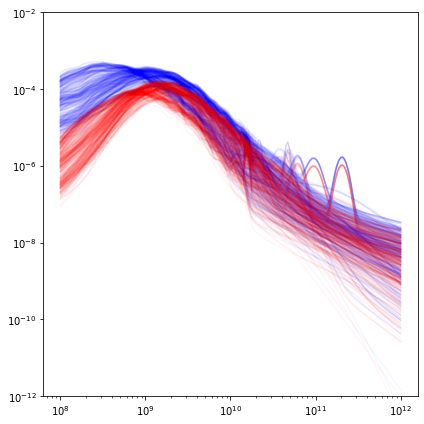

In [62]:
f_opt_lis=intminL(logM_lis)
f_opt2_lis=intlam03(logM_lis)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

# ax.loglog(10**logM_lis,dnq_dlogM_med/f_opt_lis,c='b')
# ax.fill_between(10**logM_lis,*[f_opt_lis**(-1),f_opt_lis**(-1)]*np.transpose(dnq_dlogM_90CL),color='b', alpha=0.2)

for x in dnq_dlogM_arr[:500]:
    ax.loglog(10**logM_lis,x/f_opt_lis,c='b',alpha=.03)

for x in dnq_dlogM_arr[:500]:
    ax.loglog(10**logM_lis,x/f_opt2_lis,c='r',alpha=.03)
    
    
plt.ylim(10**(-12),10**(-2))
plt.show()

The number of BHs, per $\log_{10}M$ seen with angular size larger than $\theta$ is given by
$$\frac{dN(\theta)}{d\log_{10}M}=\frac{4\pi}{3}\left(\frac{G M}{\theta}\right)^3\frac{dn}{d\log_{10}M}$$
For a log-normal distribution, this peaks at $M=\left<M\right>e^{3\ln^2(10)\sigma_{\log M}^2}$, which can be huge.

In [63]:
    # conversion from Mpc^{-3} to number of BHs. The factor is 4\pi/3(G Msun/𝜇as)^3
vol_mass=4.0282*10**(-24)#Mpc^3

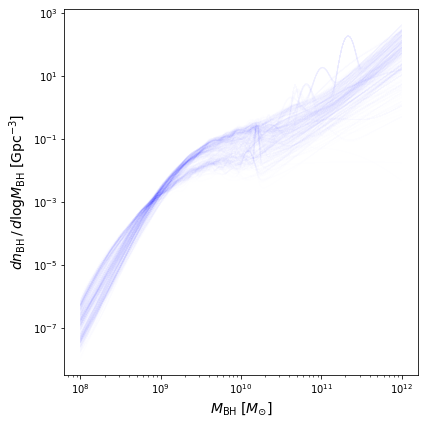

In [64]:
M3rho_Mq_arr=np.array([(vol_mass*10**(3*x))*Gauss(x,mass_new,dmass_new) for x in logM_lis])

#dot product with the Bolean array
dNq_dlogM_arr=(dist_bool@np.transpose(M3rho_Mq_arr))/vol_max

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

for x in dNq_dlogM_arr[:500]:
    ax.loglog(10**logM_lis,x,c='b',alpha=.003)

# for x in dNq_dlogM_arr[:500]:
#     ax.loglog(10**logM_lis,x/f_opt2_lis,c='r',alpha=.003)

    
plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
# plt.ylim(10**(-5),10**8)
# plt.xlim(10**(8),10**20)

plt.show()

### Another try at the BH mass function

In [65]:
mass_bins=np.linspace(8,12,50)
dbins=mass_bins[1]-mass_bins[0]
rand_mass=np.array([np.random.normal(mass_new, dmass_new) for i in trange(rand_N, leave=False)])
histarr=np.array([np.histogram(x[dist_bool[i]],bins=mass_bins,density=True)[0]*len(x[dist_bool[i]])/vol_max for i,x in enumerate(tqdm(rand_mass, leave=False))])
# for i in trange(2):
#     rand_mass=np.array([np.random.normal(mass_new, dmass_new) for i in trange(rand_N, leave=False)])
#     histarr=np.append(histarr,np.array([np.histogram(x[dist_bool[i]],bins=mass_bins)[0]/dbins for i,x in enumerate(tqdm(rand_mass, leave=False))]),axis=0)


In [66]:
dnq_dlogM_med=np.array([np.median(x) for x in tqdm(np.transpose(histarr))])
dnq_dlogM_90CL=np.array([az.hdi(x,0.9) for x in tqdm(np.transpose(histarr))])

In [67]:
#from astro-ph/0405585, the Mass function is given by
nBH_over_LogM_known=0.106985*np.exp(- 0.230259*logM_lis-0.000149614*np.exp(1.12827*logM_lis))

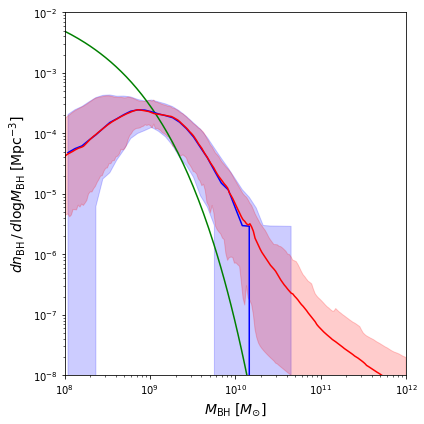

In [68]:
cord_mass=(mass_bins[1:]+mass_bins[:-1])/2
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
f_opt_cord=intminL(cord_mass)
f_opt_lis=intminL(logM_lis)

# for i in tqdm(histarr):
#     ax.step(10**mass_bins[1:],i,color='b',alpha=.003)

ax.loglog(10**logM_lis,nBH_over_LogM_known,c='g')

ax.loglog(10**cord_mass,dnq_dlogM_med/f_opt_cord,c='b')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dnq_dlogM_90CL),color='b', alpha=0.2)

ax.loglog(10**logM_lis,dnq_dlogM_med2/f_opt_lis,c='r')
ax.fill_between(10**logM_lis,*[f_opt_lis**(-1),f_opt_lis**(-1)]*np.transpose(dnq_dlogM_90CL2),color='r', alpha=0.2)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Mpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

plt.xlim(10**8,10**12)
plt.ylim(10**(-8),10**(-2))


plt.savefig('n_vs_M.jpg')

plt.show()

In [22]:
#from astro-ph/0405585, the total Mass function is given by
NBH_over_LogM_known=4.30959*10**(-25)*np.exp(6.6775*logM_lis-0.000149614*np.exp(1.12827*logM_lis))

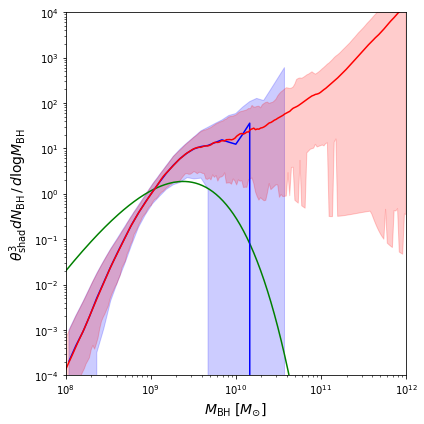

In [33]:
nq_to_NBH_hist=10**(3*cord_mass)*vol_mass*f_opt_cord**(-1)
nq_to_NBH_gau=10**(3*logM_lis)*vol_mass*f_opt_lis**(-1)

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**logM_lis,NBH_over_LogM_known,c='g')

ax.loglog(10**cord_mass,nq_to_NBH_hist*dnq_dlogM_med,c='b')
ax.fill_between(10**cord_mass,*[nq_to_NBH_hist,nq_to_NBH_hist]*np.transpose(dnq_dlogM_90CL),color='b', alpha=0.2)

ax.loglog(10**logM_lis,nq_to_NBH_gau*dnq_dlogM_med2,c='r')
ax.fill_between(10**logM_lis,*[nq_to_NBH_gau,nq_to_NBH_gau]*np.transpose(dnq_dlogM_90CL2),color='r', alpha=0.2)

plt.ylabel(r'${\theta_{\rm shad}^3dN_{\rm BH}}\,/\,{d\log M_{\rm BH}}$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

plt.xlim(10**8,10**12)
plt.ylim(10**(-4),10**(4))


plt.savefig('thetaN_vs_M.jpg')


plt.show()

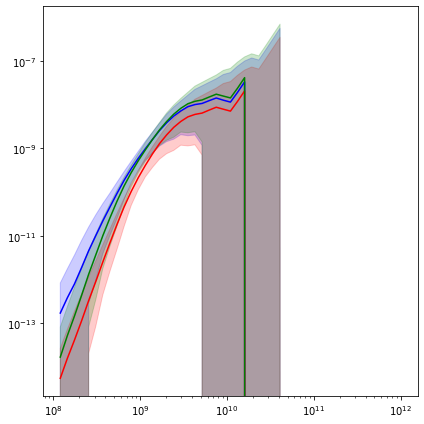

In [24]:
mass_points=mass_bins[1:]
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**mass_points[mass_points>8],(10**(3*mass_points[mass_points>8]))*dnq_dlogM_med[mass_points>8]*vol_mass/vol_max/intminL(mass_points[mass_points>8]),c='b')
ax.fill_between(10**mass_points[mass_points>8],*[(10**(3*mass_points[mass_points>8]))*vol_mass/vol_max/intminL(mass_points[mass_points>8]),(10**(3*mass_points[mass_points>8]))*vol_mass/vol_max/intminL(mass_points[mass_points>8])]*np.transpose(dnq_dlogM_90CL[mass_points>8]),color='b', alpha=0.2)

ax.loglog(10**mass_points[mass_points>8],(10**(3*mass_points[mass_points>8]))*dnq_dlogM_med[mass_points>8]*vol_mass/vol_max/intlam03(mass_points[mass_points>8]),c='r')
ax.fill_between(10**mass_points[mass_points>8],*[(10**(3*mass_points[mass_points>8]))*vol_mass/vol_max/intlam03(mass_points[mass_points>8]),(10**(3*mass_points[mass_points>8]))*vol_mass/vol_max/intlam03(mass_points[mass_points>8])]*np.transpose(dnq_dlogM_90CL[mass_points>8]),color='r', alpha=0.2)

ax.loglog(10**mass_points[mass_points>8],(10**(3*mass_points[mass_points>8]))*dnq_dlogM_med[mass_points>8]*vol_mass/vol_max/intlam06(mass_points[mass_points>8]),c='g')
ax.fill_between(10**mass_points[mass_points>8],*[(10**(3*mass_points[mass_points>8]))*vol_mass/vol_max/intlam06(mass_points[mass_points>8]),(10**(3*mass_points[mass_points>8]))*vol_mass/vol_max/intlam06(mass_points[mass_points>8])]*np.transpose(dnq_dlogM_90CL[mass_points>8]),color='g', alpha=0.2)


plt.show()

# Distance function
We have that 
$$\frac{dN_{\rm BH}(\theta)}{d\log r}=4\pi \ln(10)r^3n_{\rm BH}\left(M_{\rm BH}>\frac{\theta r}{G}\right)$$

In [25]:
# [𝜇as][Mpc]/G -> M_sub
qr_to_mass=1.01312*10**8

logr_lis=np.linspace(-2,5,50)

theta_0_shad_logr2=4*np.pi*np.log(10)*10**(3*logr_lis)*np.array([
                            np.trapz((dnq_dlogM_med2/f_opt_lis)[logM_lis>np.log10(qr_to_mass*10**x)+0],logM_lis[logM_lis>np.log10(qr_to_mass*10**x)+0]) 
                           for x in tqdm(logr_lis)])

theta_1_shad_logr2=4*np.pi*np.log(10)*10**(3*logr_lis)*np.array([
                            np.trapz((dnq_dlogM_med2/f_opt_lis)[logM_lis>np.log10(qr_to_mass*10**x)+1],logM_lis[logM_lis>np.log10(qr_to_mass*10**x)+1]) 
                           for x in tqdm(logr_lis)])

theta_m1_shad_logr2=4*np.pi*np.log(10)*10**(3*logr_lis)*np.array([
                            np.trapz((dnq_dlogM_med2/f_opt_lis)[logM_lis>np.log10(qr_to_mass*10**x)-1],logM_lis[logM_lis>np.log10(qr_to_mass*10**x)-1]) 
                           for x in tqdm(logr_lis)])


theta_0_shad_logr=4*np.pi*np.log(10)*10**(3*logr_lis)*np.array([
                            np.trapz((dnq_dlogM_med/f_opt_cord)[cord_mass>np.log10(qr_to_mass*10**x)+0],cord_mass[cord_mass>np.log10(qr_to_mass*10**x)+0]) 
                           for x in tqdm(logr_lis)])

theta_1_shad_logr=4*np.pi*np.log(10)*10**(3*logr_lis)*np.array([
                            np.trapz((dnq_dlogM_med/f_opt_cord)[cord_mass>np.log10(qr_to_mass*10**x)+1],cord_mass[cord_mass>np.log10(qr_to_mass*10**x)+1]) 
                           for x in tqdm(logr_lis)])

theta_m1_shad_logr=4*np.pi*np.log(10)*10**(3*logr_lis)*np.array([
                            np.trapz((dnq_dlogM_med/f_opt_cord)[cord_mass>np.log10(qr_to_mass*10**x)-1],cord_mass[cord_mass>np.log10(qr_to_mass*10**x)-1]) 
                           for x in tqdm(logr_lis)])

In [26]:
#from astro-ph/0405585, the total distance function is given by
import mpmath

def NBH_theta_logr(theta,logr):
    return 0.454695*10**(3*logr)*float(mpmath.nstr(mpmath.gammainc(-0.204082,1.2524*(theta*10**logr)**0.49)))
NBH_over_Logr_1=np.array([NBH_theta_logr(10,x) for x in logr_lis])
NBH_over_Logr_0=np.array([NBH_theta_logr(1,x) for x in logr_lis])
NBH_over_Logr_m1=np.array([NBH_theta_logr(.1,x) for x in logr_lis])

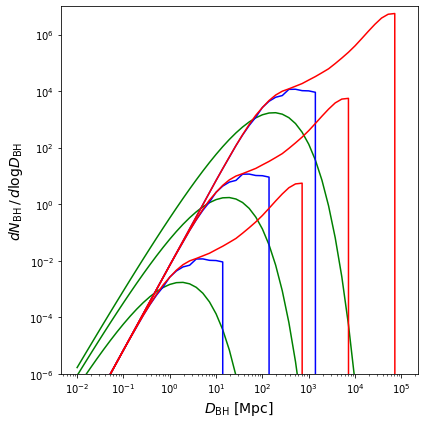

In [32]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**logr_lis,NBH_over_Logr_1,c='g')
ax.loglog(10**logr_lis,NBH_over_Logr_0,c='g')
ax.loglog(10**logr_lis,NBH_over_Logr_m1,c='g')



ax.loglog(10**logr_lis,theta_0_shad_logr,c='b')
ax.loglog(10**logr_lis,theta_1_shad_logr,c='b')
ax.loglog(10**logr_lis,theta_m1_shad_logr,c='b')

ax.loglog(10**logr_lis,theta_0_shad_logr2,c='r')
ax.loglog(10**logr_lis,theta_1_shad_logr2,c='r')
ax.loglog(10**logr_lis,theta_m1_shad_logr2,c='r')
# ax.fill_between(10**logM_lis,*[nq_to_NBH_gau,nq_to_NBH_gau]*np.transpose(dnq_dlogM_90CL2),color='r', alpha=0.2)

plt.ylabel(r'${dN_{\rm BH}}\,/\,{d\log D_{\rm BH}}$', fontsize=14)
plt.xlabel(r'$D_{\rm BH}\;\left[\rm{Mpc}\right]$', fontsize=14)

# plt.xlim(10**8,10**12)
plt.ylim(10**(-6),10**(7))
plt.savefig('N_vs_D.jpg')

plt.show()

# Statistics - shadow

## Functions

In [307]:
# Probability that theta_shad>theta
def F_shad(x,sig):
    xos=x/(np.sqrt(2)*sig)
    return x*erfc(xos)-np.sqrt(2/np.pi)*sig*np.exp(-xos**2)

def P_shad(Q,sig):
    Sig=np.sqrt(sig**2+(np.log10(3)/3)**2)
    return (1/(4*0.17))*(F_shad(Q+0.17,Sig)-F_shad(Q-0.17,Sig))

def Gauss(m,mb,sig):
    return 1/(sig * np.sqrt(2 * np.pi)) *np.exp( - (m - mb)**2 / (2 * sig**2) )

In [308]:
# Log of the BH shaddow array Nrandom*NQ
qshadarr=np.array([np.log10(msun_over_Mpc_to_muas)+mass_new-np.log10(x) for x in tqdm(lam_dist)]) 

We denote $p={\{\rm random\;points\}}\;\;q=\{\rm quasars\}$, and define the probability that the shaddow of a qusar $q$, seen by a point $p$ is larer than $\theta$ by $P_{p,q}(\theta)$. 
However, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [309]:
# Generating P_{p,q}/f({0.1,0,5})
theta_m1_shad_arr=np.array([P_shad(-1-x[dist_bool[i]],dmass_new[dist_bool[i]])/(lamlis[dist_bool[i]]) for i,x in enumerate(tqdm(qshadarr))])
theta_0_shad_arr=np.array([P_shad(0-x[dist_bool[i]],dmass_new[dist_bool[i]])/(lamlis[dist_bool[i]]) for i,x in enumerate(tqdm(qshadarr))])
theta_1_shad_arr=np.array([P_shad(1-x[dist_bool[i]],dmass_new[dist_bool[i]])/(lamlis[dist_bool[i]]) for i,x in enumerate(tqdm(qshadarr))])

## Predicted observed BH mass function as a function of resolution

Each quasar comes with a mass PDF $\rho_q(\log_{10} M_q)$. We therefore generate $|p|$ samples of the BH mass function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [310]:
bins=np.linspace(8,11.4,200)
rho_LogM_bins_vec=np.array([Gauss(x,mass_new,dmass_new) for x in bins])

In [311]:
theta_m1_shad_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_m1_shad_arr))])
theta_0_shad_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_0_shad_arr))])
theta_1_shad_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_1_shad_arr))])

In [312]:
theta_m1_shad_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_shad_LogM))])
theta_0_shad_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_shad_LogM))])
theta_1_shad_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_shad_LogM))])

theta_m1_shad_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_shad_LogM))])
theta_0_shad_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_shad_LogM))])
theta_1_shad_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_shad_LogM))])

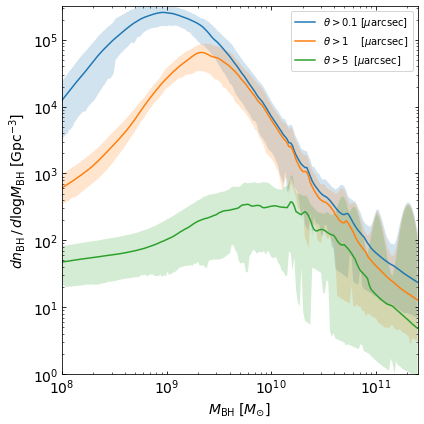

In [313]:
vol=4*np.pi*(r_max/1000)**3/3 
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,theta_m1_shad_mean_LogM/vol,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_shad_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_0_shad_mean_LogM/vol,label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_0_shad_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_1_shad_mean_LogM/vol,label=r'$\theta>5\;\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_1_shad_CL09_LogM), alpha=0.2)


# ax.loglog(10**bins,10**savgol_filter(np.log10(theta_m1_shad_CL09_LogM[:,0]),11,1)/vol,'.',label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')

# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(-0),10**5.5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.show()

Smooth version

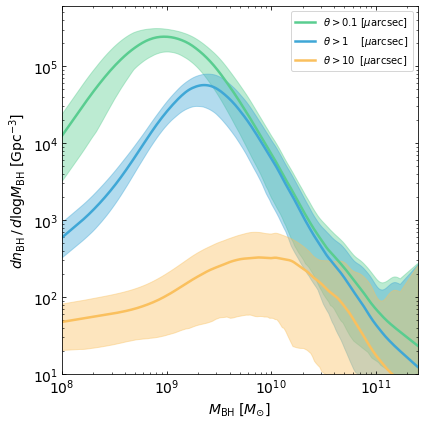

In [314]:
# colis=np.flip(sns.color_palette("Blues",n_colors=3),axis=0)
colis=np.flip(['#fac05e','#3fa7d6','#59cd90'])

smod_m1_shad_mean_LogM=10**savgol_filter(np.log10(theta_m1_shad_mean_LogM),21,1)/vol
smod_m1_shad_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_m1_shad_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_1_shad_mean_LogM=10**savgol_filter(np.log10(theta_1_shad_mean_LogM),21,1)/vol
smod_1_shad_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_1_shad_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_0_shad_mean_LogM=10**savgol_filter(np.log10(theta_0_shad_mean_LogM),21,1)/vol
smod_0_shad_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_0_shad_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)


ax.loglog(10**bins,smod_0_shad_mean_LogM,c=colis[1],linewidth=2.5,label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_0_shad_CL09_LogM,color=colis[1], alpha=0.4)

ax.loglog(10**bins,smod_1_shad_mean_LogM,c=colis[2],linewidth=2.5,label=r'$\theta>10\;\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_1_shad_CL09_LogM,color=colis[2], alpha=0.4)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('mass_shad.pdf')

plt.show()



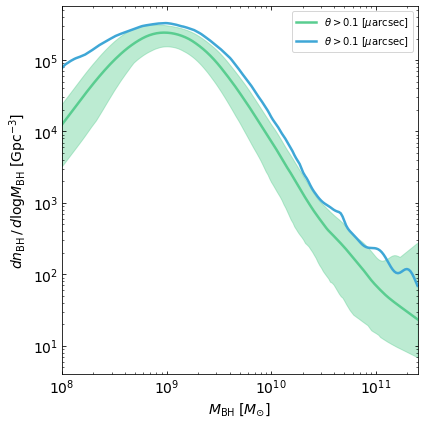

In [315]:

this=np.array([np.minimum(1,x) for x in (((2.02622*10**10)**(-1))*(10**bins))**3])
this2=np.array([np.minimum(1,x) for x in (((2.02622*9**10)**(-1))*(10**bins))**3])

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)


ax.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(intminL(bins)*Vol(z_min,z_max).to(u.Gpc**3).value) ,c=colis[1], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
# ax.loglog(10**bins,this*smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*[this,this]*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)
# ax.loglog(10**bins,this2*smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*[this2,this2]*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)


# ax.loglog(10**bins,smod_0_shad_mean_LogM,c=colis[1],linewidth=2.5,label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*smod_0_shad_CL09_LogM,color=colis[1], alpha=0.4)

# ax.loglog(10**bins,smod_1_shad_mean_LogM,c=colis[2],linewidth=2.5,label=r'$\theta>10\;\;[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*smod_1_shad_CL09_LogM,color=colis[2], alpha=0.4)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
# plt.ylim(10**(1),6*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('mass_shad.pdf')

plt.show()



## Predicted observed BH distances function as a function of resolution

Each quasar comes with a distance PDF $\rho_D(\log_{10} D_q)$. We therefore generate $|p|$ samples of the BH distances function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [175]:
short_dist=np.array([x[dist_bool[i]] for i,x in enumerate(tqdm(lam_dist))])

In [176]:
bins_D=np.linspace(-3,np.log10(r_max),50)
rho_LogD_bins_arr=np.array([[Gauss(x,np.log10(y),np.log10(3))  for y in tqdm(short_dist,leave=False)] for x in tqdm(bins_D)])

In [177]:
theta_m1_shad_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_m1_shad_arr))])
theta_0_shad_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_0_shad_arr))])
theta_1_shad_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_1_shad_arr))])

In [178]:
theta_m1_shad_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_shad_LogD))])
theta_0_shad_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_shad_LogD))])
theta_1_shad_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_shad_LogD))])

theta_m1_shad_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_shad_LogD))])
theta_0_shad_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_shad_LogD))])
theta_1_shad_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_shad_LogD))])

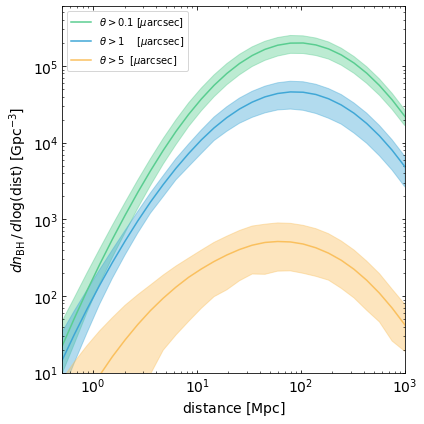

In [179]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins_D,theta_m1_shad_mean_LogD/vol,color=colis[0],label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_shad_CL09_LogD),color=colis[0], alpha=0.4)

ax.loglog(10**bins_D,theta_0_shad_mean_LogD/vol,color=colis[1],label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_0_shad_CL09_LogD),color=colis[1], alpha=0.4)

ax.loglog(10**bins_D,theta_1_shad_mean_LogD/vol,color=colis[2],label=r'$\theta>5\;\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_1_shad_CL09_LogD),color=colis[2], alpha=0.4)


# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=False,right=True)

ax.legend(loc='upper left',fontsize=10) 


# xval=10**np.linspace(-4,1,100)
# ttab=cosmo.comoving_distance(xval).value
# # forward=int1d(ttab,xval)
# # inverse=int1d(xval,ttab)
# def forward(x):
#     return np.interp(x,ttab,xval)


# def inverse(x):
#     return np.interp(x,xval,ttab)

# new_tick_locations=cosmo.comoving_distance(10**np.linspace(-1,0,2)).value
# secax = ax.secondary_xaxis('top', functions=(forward, inverse))
# secax.tick_params(axis='both', which='both', direction='in', top=True,right=True)
# secax.set_xlabel(r'$z$',fontsize=14)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log ({\rm dist})}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'${\rm distance}\;\left[{\rm Mpc}\right]$', fontsize=14)
plt.ylim(10**(1),2*10**5)
plt.xlim(5*10**(-1),r_max)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log ({\rm dist})}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'${\rm distance}\;\left[{\rm Mpc}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(5*10**(-1),r_max)

plt.savefig('dist_shad.pdf')

plt.show()

### $N_{BH}\; \rm{vs.}\; \theta$

In [180]:
median_ary=[]
CL_ary=[]
theta_range=np.linspace(-2,1.7,20)

for j in tqdm(theta_range):
    N_BH_temp=np.array([np.sum(P_shad(j-qshadarr[i][dist_bool[i]],(dmass_new)[dist_bool[i]])/lamlis[dist_bool[i]]) for i in trange(rand_N, leave=False)])
    median_ary.append(np.median(N_BH_temp))
    CL_ary.append(az.hdi(N_BH_temp, 0.9))
   

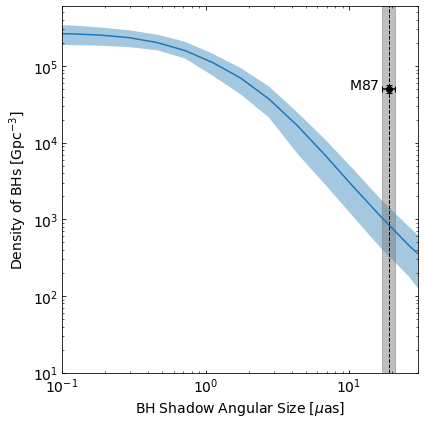

In [185]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(2*10**theta_range,np.array(median_ary)/vol)
ax.fill_between(2*10**theta_range,*np.transpose([vol**(-1),vol**(-1)]*(np.array(CL_ary)+10**(-5))), alpha=0.4)

ax.loglog(10**theta_range,theta_range*0+1,'--',color='black')

ax.axvline(x=19,c='black',ls='--',lw=1)
ax.axvspan(17, 21, alpha=0.5, color='gray')
# ax.axhline(y=50000,c='black',ls='--')
# ax.axhspan(45000, 57000, alpha=0.5, color='gray')

ax.errorbar(19,50000,6000,2,color='black',marker='o',capsize=3)

plt.text(10,50000,r'$\rm{M}87$', fontsize=14)

plt.ylim(10**(1),6*10**5)
plt.xlim(10**(-1),30)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Density\;of\;BHs\;\left[\rm{Gpc}^{-3}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Shadow\;Angular\;Size}\;\left[\mu{\rm as}\right]$', fontsize=14)

plt.savefig('tot_shad.pdf')

plt.show()

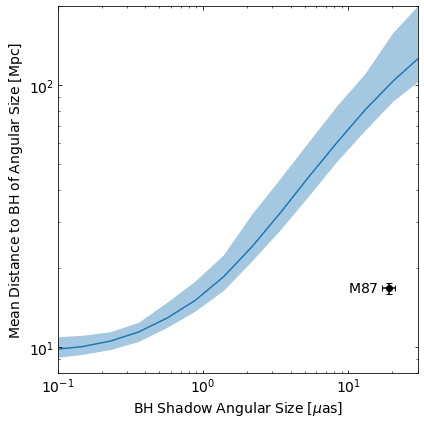

In [182]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**theta_range,r_max*np.array(median_ary)**(-1/3))
ax.fill_between(10**theta_range,*np.transpose([r_max,r_max]*((np.array(CL_ary)+10**(-10)))**(-1/3)), alpha=0.4)


# ax.axvline(x=19,c='black',ls='--',lw=1)
# ax.axvspan(17, 21, alpha=0.5, color='gray')
# ax.axhline(y=50000,c='black',ls='--')
# ax.axhspan(45000, 57000, alpha=0.5, color='gray')

ax.errorbar(19,16.8,.8,2,color='black',marker='o',capsize=3)

plt.text(10,16.2,r'$\rm{M}87$', fontsize=14)

plt.ylim(8,2*10**(2))
plt.xlim(10**(-1),30)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Mean\;Distance\;to\;BH\;of\;Angular\;Size\;\left[\rm{Mpc}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Shadow\;Angular\;Size}\;\left[\mu{\rm as}\right]$', fontsize=14)

plt.savefig('dis_shad.pdf')

plt.show()

# Statistics - Gravity

## Functions

In [30]:
# Probability that theta_grav>theta

def P_grav(Q,m,sig):
    Sig=np.sqrt(0.2965*sig**2+0.0049*m**2+0.0878)
    return erfc(Q/np.sqrt(2)/Sig)/2

# a function that returns \theta_grav in arcsec using the M-sig relation.
def qgrav(log10M,dist_Mpc):
    return 0.54*log10M-np.log10(dist_Mpc)-3.48

In [31]:
# Log of the BH grav array Nrandom*NQ
qgravarr=np.array([qgrav(mass_new,x) for x in tqdm(lam_dist)]) 

We denote $p={\{\rm random\;points\}}\;\;q=\{\rm quasars\}$, and define the probability that the shaddow of a qusar $q$, seen by a point $p$ is larer than $\theta$ by $P_{p,q}(\theta)$. 
However, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [32]:
# Generating P_{p,q}({0.1,0,5})
theta_m1_grav_arr=np.array([P_grav(-1-x[dist_bool[i]],mass_new[dist_bool[i]],dmass_new[dist_bool[i]])/lamlis[dist_bool[i]] for i,x in enumerate(tqdm(qgravarr))])
theta_0_grav_arr=np.array([P_grav(0-x[dist_bool[i]],mass_new[dist_bool[i]],dmass_new[dist_bool[i]])/lamlis[dist_bool[i]] for i,x in enumerate(tqdm(qgravarr))])
theta_1_grav_arr=np.array([P_grav(1-x[dist_bool[i]],mass_new[dist_bool[i]],dmass_new[dist_bool[i]])/lamlis[dist_bool[i]] for i,x in enumerate(tqdm(qgravarr))])




## Predicted observed BH mass function as a function of resolution

Each quasar comes with a mass PDF $\rho_q(\log_{10} M_q)$. We therefore generate $|p|$ samples of the BH mass function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [33]:
theta_m1_grav_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_m1_grav_arr))])
theta_0_grav_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_0_grav_arr))])
theta_1_grav_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_1_grav_arr))])

In [34]:
theta_m1_grav_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_grav_LogM))])
theta_0_grav_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_grav_LogM))])
theta_1_grav_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_grav_LogM))])

theta_m1_grav_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_grav_LogM))])
theta_0_grav_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_grav_LogM))])
theta_1_grav_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_grav_LogM))])

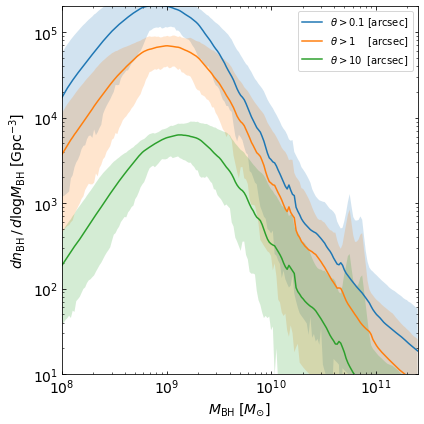

In [35]:

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,theta_m1_grav_mean_LogM/vol,label=r'$\theta>0.1\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_grav_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_0_grav_mean_LogM/vol,label=r'$\theta>1\;\;\;\;\,[\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_0_grav_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_1_grav_mean_LogM/vol,label=r'$\theta>10\;\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_1_grav_CL09_LogM), alpha=0.2)


# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(1),2*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.show()

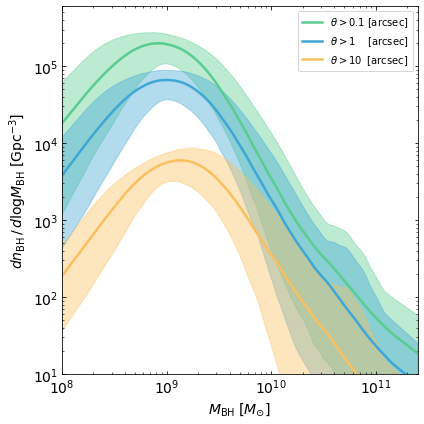

In [36]:
smod_m1_grav_mean_LogM=10**savgol_filter(np.log10(theta_m1_grav_mean_LogM),21,1)/vol
smod_m1_grav_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_m1_grav_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_1_grav_mean_LogM=10**savgol_filter(np.log10(theta_1_grav_mean_LogM),21,1)/vol
smod_1_grav_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_1_grav_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_0_grav_mean_LogM=10**savgol_filter(np.log10(theta_0_grav_mean_LogM),21,1)/vol
smod_0_grav_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_0_grav_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,smod_m1_grav_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_m1_grav_CL09_LogM,color=colis[0], alpha=0.4)


ax.loglog(10**bins,smod_0_grav_mean_LogM,c=colis[1],linewidth=2.5,label=r'$\theta>1\;\;\;\;\,[\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_0_grav_CL09_LogM,color=colis[1], alpha=0.4)
5
ax.loglog(10**bins,smod_1_grav_mean_LogM,c=colis[2],linewidth=2.5,label=r'$\theta>10\;\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_1_grav_CL09_LogM,color=colis[2], alpha=0.4)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('mass_grav.pdf')

plt.show()

## Predicted observed BH distances function as a function of resolution

Each quasar comes with a distance PDF $\rho_D(\log_{10} D_q)$. We therefore generate $|p|$ samples of the BH distances function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [37]:
theta_m1_grav_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_m1_grav_arr))])
theta_0_grav_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_0_grav_arr))])
theta_1_grav_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_1_grav_arr))])

In [38]:
theta_m1_grav_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_grav_LogD))])
theta_0_grav_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_grav_LogD))])
theta_1_grav_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_grav_LogD))])

theta_m1_grav_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_grav_LogD))])
theta_0_grav_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_grav_LogD))])
theta_1_grav_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_grav_LogD))])

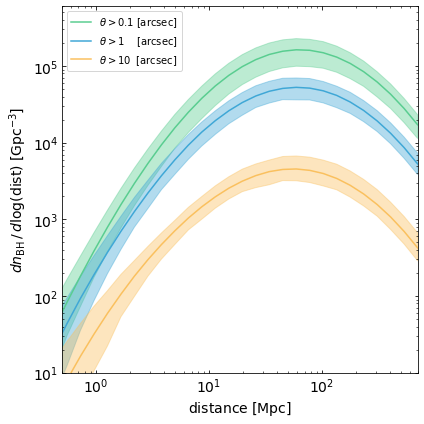

In [39]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins_D,theta_m1_grav_mean_LogD/vol,color=colis[0],label=r'$\theta>0.1\;[\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_grav_CL09_LogD),color=colis[0], alpha=0.4)

ax.loglog(10**bins_D,theta_0_grav_mean_LogD/vol,color=colis[1],label=r'$\theta>1\;\;\;\;\,[\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_0_grav_CL09_LogD),color=colis[1], alpha=0.4)

ax.loglog(10**bins_D,theta_1_grav_mean_LogD/vol,color=colis[2],label=r'$\theta>10\;\;[\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_1_grav_CL09_LogD),color=colis[2], alpha=0.4)


# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log ({\rm dist})}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'${\rm distance}\;\left[{\rm Mpc}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(5*10**(-1),r_max)

ax.legend(loc='upper left',fontsize=10) 

plt.savefig('dist_grav.pdf')

plt.show()

### $N_{BH}\; \rm{vs.}\; \theta$

In [40]:
median_grav_ary=[]
CL_grav_ary=[]
theta_range=np.linspace(-2,3,20)

for j in tqdm(theta_range):
    N_BH_temp=np.array([np.sum(P_grav(j-qgravarr[i][dist_bool[i]],mass_new[dist_bool[i]],(dmass_new)[dist_bool[i]])/lamlis[dist_bool[i]]) for i in trange(rand_N, leave=False)])
    median_grav_ary.append(np.median(N_BH_temp))
    CL_grav_ary.append(az.hdi(N_BH_temp, 0.9))
   

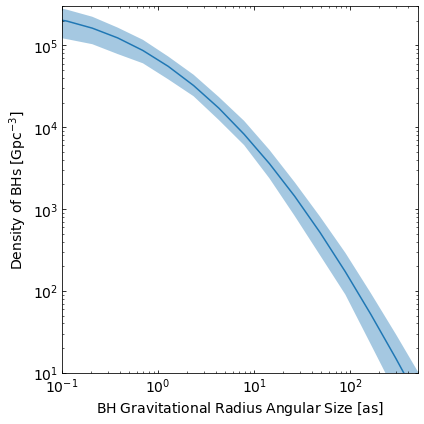

In [41]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**theta_range,np.array(median_grav_ary)/vol)
ax.fill_between(10**theta_range,*np.transpose([vol**(-1),vol**(-1)]*(np.array(CL_grav_ary)+10**(-5))), alpha=0.4)

ax.loglog(10**theta_range,theta_range*0+1,'--',color='black')

plt.ylim(10**(1),3*10**5)
plt.xlim(10**(-1),500)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Density\;of\;BHs\;\left[\rm{Gpc}^{-3}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Gravitational\;Radius\;Angular\;Size}\;\left[{\rm as}\right]$', fontsize=14)

plt.savefig('tot_grav.pdf')

plt.show()

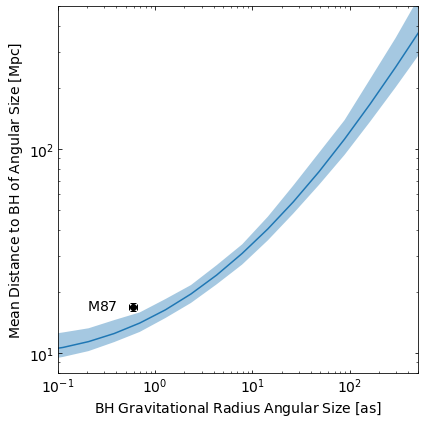

In [57]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**theta_range,r_max*np.array(median_grav_ary)**(-1/3))
ax.fill_between(10**theta_range,*np.transpose([r_max,r_max]*((np.array(CL_grav_ary)+10**(-10)))**(-1/3)), alpha=0.4)


# ax.axvline(x=19,c='black',ls='--',lw=1)
# ax.axvspan(17, 21, alpha=0.5, color='gray')
# ax.axhline(y=50000,c='black',ls='--')
# ax.axhspan(45000, 57000, alpha=0.5, color='gray')

ax.errorbar(qgrav(np.log10(6.5*10**9),16.8),16.8,.8,.1*qgrav(np.log10(6.5*10**9),16.8),color='black',marker='o',capsize=3)

plt.text(0.2,16.2,r'$\rm{M}87$', fontsize=14)

plt.ylim(8,5*10**(2))
plt.xlim(10**(-1),500)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Mean\;Distance\;to\;BH\;of\;Angular\;Size\;\left[\rm{Mpc}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Gravitational\;Radius\;Angular\;Size}\;\left[{\rm as}\right]$', fontsize=14)

plt.savefig('dis_grav.pdf')

plt.show()

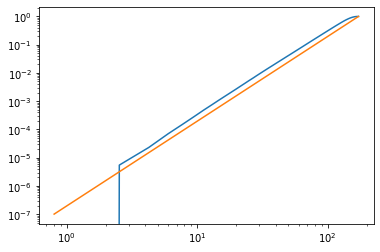

In [347]:
limdis=lam_dist[dist_bool]
disbin=np.linspace(np.min(limdis),np.max(limdis),100)
cdfdis=np.array([len(limdis[limdis<i]) for i in disbin])
plt.loglog(disbin,cdfdis/len(limdis))
plt.loglog(disbin,(disbin/np.max(limdis))**3)
plt.show()

In [317]:
scat=np.transpose(np.vstack((lam_dist[dist_bool],np.tile(mass_new,(rand_N,1))[dist_bool],qshadarr[dist_bool],qgravarr[dist_bool])))

Removed no burn in


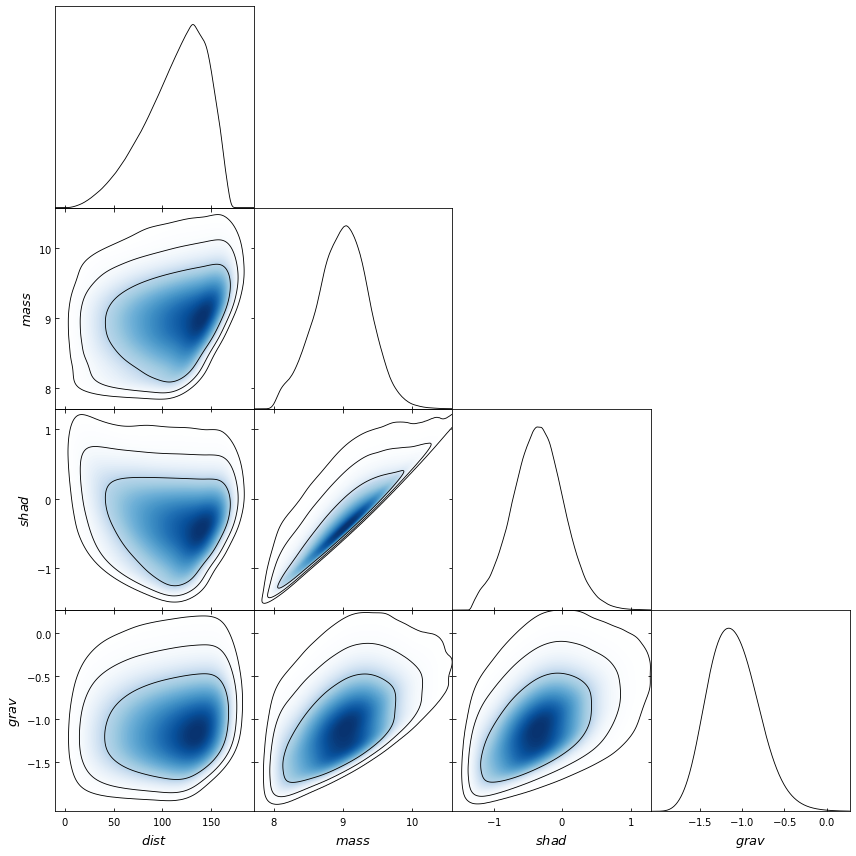

In [318]:
names2 = ["x%s"%i for i in range(4)]
labels2 =  ['dist','mass','shad','grav']



samples2 = MCSamples(samples=scat,names = names2, labels = labels2,settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99,.999]})


# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d(samples, 'x0', 'x1', filled=True)
# g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Triangle plot
g = plots.get_subplot_plotter(subplot_size=3)
g.settings.num_plot_contours = 3
g.triangle_plot(samples2,  shaded=True)
g.add_x_bands(1.3,.1)

plt.savefig('shadow_tri.pdf')

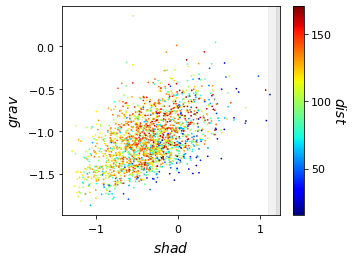

In [319]:
plots.set_active_style();

g = plots.get_single_plotter(width_inch=5)
g.plot_3d(samples2, ['x2', 'x3', 'x0'],settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99]})
g.add_x_bands(1.3,.1)

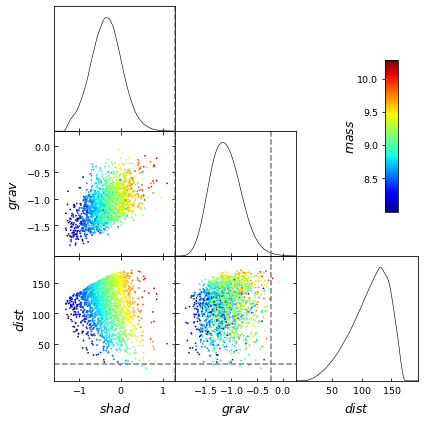

In [324]:
plots.set_active_style();

g = plots.get_subplot_plotter(width_inch=6)

# you can adjust the scaling factor if font sizes are too small when
# making many subplots in a fixed size (default=2 would give smaller fonts)
g.settings.scaling_factor = 1
g.triangle_plot(samples2, ['x2', 'x3','x0'], 
                plot_3d_with_param='x1')

for ax in g.subplots[:,0]:
    ax.axvline(np.log10(19), color='gray', ls='--')
    
for ax in g.subplots[1:,1]:
    ax.axvline(np.log10(qgrav(np.log10(6.5*10**9),16.8)), color='gray', ls='--')
    
for ax in g.subplots[2,:2]:
    ax.axhline(16.8, color='gray', ls='--')


plt.show()
               

In [128]:
1-len(qshadarr[dist_bool][qshadarr[dist_bool]>np.log10(17)])/len(qshadarr[dist_bool])

0.9989864863990718

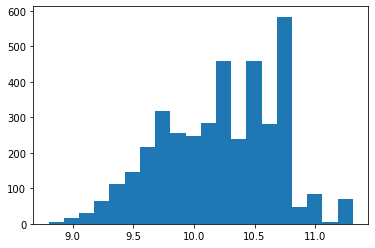

In [127]:
plt.hist(np.tile(mass_new,(rand_N,1))[dist_bool][qshadarr[dist_bool]>np.log10(17)],20)
plt.show()

In [351]:
from scipy.interpolate import UnivariateSpline
intfi=UnivariateSpline(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(intminL(bins)*Vol(z_min,z_max).to(u.Gpc**3).value))
intfi.integral(10**8,10**12)

1259722666139293.5

In [354]:
Phiarr=np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(Vol(z_min,z_max).to(u.Gpc**3).value)
np.trapz(Phiarr*10**(2*bins),10**bins)

2.0387806097511585e+33

In [356]:
Phiarr=np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(Vol(z_min,z_max).to(u.Gpc**3).value)
np.savetxt('arr.txt',Phiarr)

In [357]:
bins

array([ 8.        ,  8.01708543,  8.03417085,  8.05125628,  8.06834171,
        8.08542714,  8.10251256,  8.11959799,  8.13668342,  8.15376884,
        8.17085427,  8.1879397 ,  8.20502513,  8.22211055,  8.23919598,
        8.25628141,  8.27336683,  8.29045226,  8.30753769,  8.32462312,
        8.34170854,  8.35879397,  8.3758794 ,  8.39296482,  8.41005025,
        8.42713568,  8.44422111,  8.46130653,  8.47839196,  8.49547739,
        8.51256281,  8.52964824,  8.54673367,  8.5638191 ,  8.58090452,
        8.59798995,  8.61507538,  8.6321608 ,  8.64924623,  8.66633166,
        8.68341709,  8.70050251,  8.71758794,  8.73467337,  8.75175879,
        8.76884422,  8.78592965,  8.80301508,  8.8201005 ,  8.83718593,
        8.85427136,  8.87135678,  8.88844221,  8.90552764,  8.92261307,
        8.93969849,  8.95678392,  8.97386935,  8.99095477,  9.0080402 ,
        9.02512563,  9.04221106,  9.05929648,  9.07638191,  9.09346734,
        9.11055276,  9.12763819,  9.14472362,  9.16180905,  9.17